<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/2-2-data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 데이터 증강

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

이 튜토리얼은 이미지 회전과 같은 임의의(그러나 현실적인) 변환을 적용하여 훈련 세트의 다양성을 증가시키는 기술인 데이터 증강을 예를 보여줍니다.

다음 두 가지 방법으로 데이터 증강을 적용하는 방법을 배우게 됩니다.

- `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip` 및 `tf.keras.layers.RandomRotation`와 같은 Keras 전처리 레이어 사용
- `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop` 및 `tf.image.stateless_random*`와 같은 `tf.image` 메서드 사용

## 설정

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## 데이터세트 다운로드

이 튜토리얼에서는 [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) 데이터세트를 사용합니다. 편의를 위해 [TensorFlow Datasets](https://www.tensorflow.org/datasets)를 사용하여 데이터세트를 다운로드합니다. 데이터를 가져오는 다른 방법에 대해 알아보려면 [이미지 로드](https://www.tensorflow.org/tutorials/load_data/images) 튜토리얼을 확인하세요.


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색하고 이를 사용하여 데이터 증강을 수행하겠습니다.

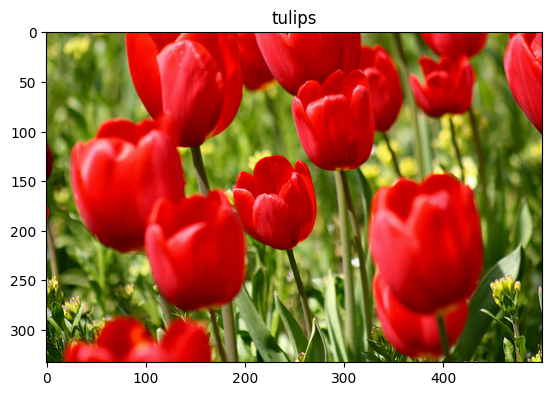

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Keras 전처리 레이어 사용하기

### 크기 및 배율 조정하기


Keras 전처리 레이어를 사용하여 일관된 형상으로 이미지 크기를 조정하고(`tf.keras.layers.Resizing`) 픽셀 값의 크기를 재조정(`tf.keras.layers.Rescaling`)할 수 있습니다.

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

참고: 위의 크기 조정 레이어는 픽셀 값을 `[0, 1]` 범위로 표준화합니다. 대신 `[-1, 1]`을 원한다면 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`을 작성합니다.


이러한 레이어를 이미지에 적용한 결과를 시각화할 수 있습니다.

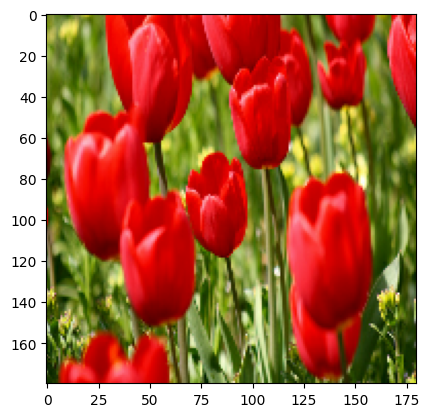

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

픽셀이 `[0, 1]` 범위에 있는지 확인합니다.

In [8]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### 데이터 증강

`tf.keras.layers.RandomFlip` 및 `tf.keras.layers.RandomRotation`과 같은 Keras 전처리 레이어를 데이터 증강에도 사용할 수 있습니다.

몇 개의 전처리 레이어를 만들어 동일한 이미지에 반복적으로 적용 해 보겠습니다.

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [10]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

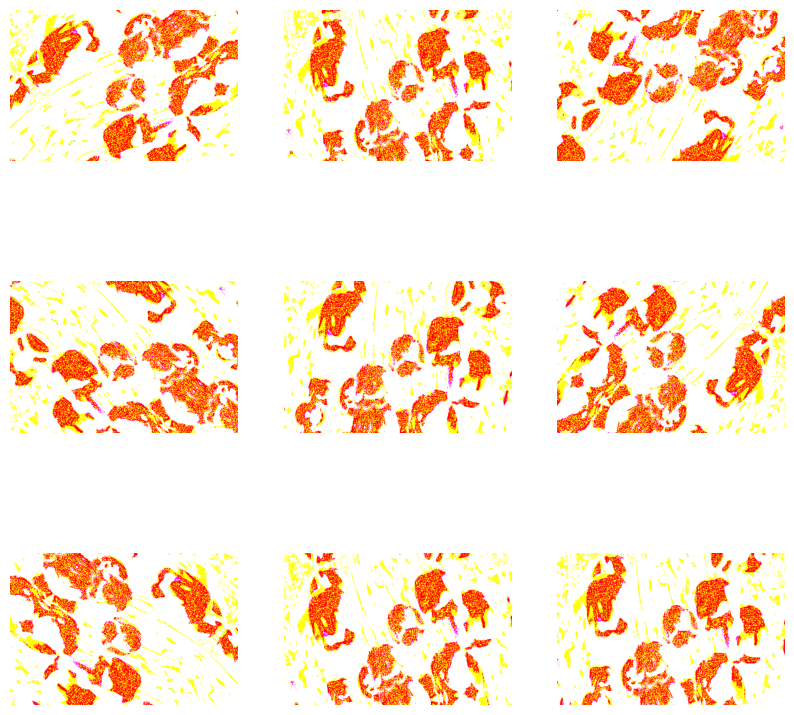

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

`tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom` 등을 포함하여 데이터 증강에 사용할 수 있는 다양한 전처리 레이어가 있습니다.

### Keras 전처리 레이어를 사용하기 위한 두 가지 옵션

중요한 절충을 통해 이러한 전처리 레이어를 사용할 수 있는 두 가지 방법이 있습니다.

#### 옵션 1: 전처리 레이어를 모델의 일부로 만들기

In [12]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

이 경우 유의해야 할 두 가지 중요한 사항이 있습니다.

- 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 GPU 가속을 이용합니다.

- `model.save`를 사용하여 모델을 내보낼 때 전처리 레이어가 모델의 나머지 부분과 함께 저장됩니다. 나중에 이 모델을 배포하면 레이어 구성에 따라 이미지가 자동으로 표준화됩니다. 이를 통해 서버측 논리를 다시 구현해야 하는 노력을 덜 수 있습니다.

참고: 데이터 증강은 테스트할 때 비활성화되므로 입력 이미지는 `model.fit`(`model.evaluate` 또는 `model.predict`가 아님) 호출 중에만 증강됩니다.

#### 옵션 2: 데이터세트에 전처리 레이어 적용하기

In [13]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

이 접근 방식에서는 `Dataset.map`을 사용하여 증강 이미지 배치를 생성하는 데이터세트를 만듭니다. 이 경우에는 다음과 같습니다.

- 데이터 증강은 CPU에서 비동기적으로 이루어지며 차단되지 않습니다. 아래와 같이 `Dataset.prefetch`를 사용하여 GPU에서 모델 훈련을 데이터 전처리와 중첩할 수 있습니다.
- 이 경우, 전처리 레이어는 `Model.save`를 호출할 때 모델과 함께 내보내지지 않습니다. 저장하기 전에 이 레이어를 모델에 연결하거나 서버측에서 다시 구현해야 합니다. 훈련 후, 내보내기 전에 전처리 레이어를 연결할 수 있습니다.


[이미지 분류](classification.ipynb) 튜토리얼에서 첫 번째 옵션의 예를 볼 수 있습니다. 여기에서는 두 번째 옵션을 살펴보겠습니다.

### 데이터세트에 전처리 레이어 적용하기

앞서 생성한 Keras 전처리 레이어로 훈련, 검증 및 테스트 데이터세트를 구성합니다. 또한 병렬 읽기 및 버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 배치를 생성하여 성능을 높이도록 데이터세트를 구성합니다. [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance) 가이드에서 데이터세트 성능에 대해 자세히 알아볼 수 있습니다.

참고: 데이터 증강은 훈련 세트에만 적용해야 합니다.

In [14]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 모델 훈련하기

완전함을 위해 이제 방금 준비한 데이터세트를 사용하여 모델을 훈련합니다.

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 정확도를 위해 조정되지 않았습니다(메커니즘을 보여주는 것이 목표임).

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

`tf.keras.optimizers.Adam` 옵티마이저 및 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달하세요.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

몇 epoch 동안 훈련합니다:

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 301ms/step - accuracy: 0.3107 - loss: 1.7069 - val_accuracy: 0.5368 - val_loss: 1.1286
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.5468 - loss: 1.1103 - val_accuracy: 0.6294 - val_loss: 1.0369
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.5940 - loss: 1.0338 - val_accuracy: 0.6349 - val_loss: 0.9955
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.6262 - loss: 0.9612 - val_accuracy: 0.6349 - val_loss: 0.9282
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.6498 - loss: 0.8896 - val_accuracy: 0.6730 - val_loss: 0.8865


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

### 사용자 정의 데이터 증강

사용자 정의 데이터 증강 레이어를 생성할 수도 있습니다.

튜토리얼의 이 섹션에서는 이를 수행하는 두 가지 방법을 보여줍니다.

- 먼저 `tf.keras.layers.Lambda` 레이어를 생성합니다. 이것은 간결한 코드를 작성하는 좋은 방법입니다.
- 다음으로, 더 많은 제어를 제공하는 [서브클래싱](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 새 레이어를 작성합니다.

두 레이어는 일부 확률에 따라 이미지의 색상을 무작위로 반전시킵니다.

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

다음으로 [서브클래싱](https://www.tensorflow.org/guide/keras/custom_layers_and_models)하여 사용자 정의 레이어를 구현합니다.

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

위의 옵션 1과 2의 설명에 따라 이 두 레이어를 모두 사용할 수 있습니다.

## tf.image 사용하기

위의 Keras 전처리 유틸리티는 편리합니다. 그러나 더 세밀한 제어를 위해서는 `tf.data` 및 `tf.image`를 사용하여 자체 데이터 증강 파이프라인 또는 레이어를 작성할 수 있습니다. [TensorFlow 추가 이미지: 작업](https://www.tensorflow.org/addons/tutorials/image_ops) 및 [TensorFlow I/O: 색 공간 변환](https://www.tensorflow.org/io/tutorials/colorspace)도 살펴보면 좋습니다.

꽃 데이터세트는 이전에 데이터 증강으로 구성되었으므로 다시 가져와서 새로 시작하겠습니다.

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

작업할 이미지를 가져옵니다.

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

다음 함수를 사용하여 원본 이미지와 증강 이미지를 나란히 시각화하고 비교하겠습니다.

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 데이터 증강

#### 이미지 뒤집기

`tf.image.flip_left_right`를 사용하여 이미지를 수직 또는 수평으로 뒤집습니다.

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### 이미지를 그레이스케일로 만들기

`tf.image.rgb_to_grayscale`을 사용하여 이미지를 그레이스케일로 만들 수 있습니다.

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### 이미지 포화시키기

채도 계수를 제공하여 `tf.image.adjust_saturation`으로 이미지를 포화시킵니다.

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 이미지 밝기 변경하기

밝기 계수를 제공하여 `tf.image.adjust_brightness`로 이미지의 밝기를 변경합니다.

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 이미지 가운데 자르기

`tf.image.central_crop`을 사용하여 중앙에서 원하는 이미지 부분까지 이미지를 자릅니다.

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### 이미지 회전하기

`tf.image.rot90`을 사용하여 이미지를 90도 회전합니다.

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### 무작위 변환

경고: `tf.image.random*` 및 `tf.image.stateless_random*`의 두 가지 무작위 이미지 연산 세트가 있습니다. `tf.image.random*` 연산은 되도록 사용하지 않는 것이 좋은데, TF 1.x의 이전 RNG를 사용하기 때문입니다. 대신 이 튜토리얼에서 소개된 무작위 이미지 연산을 사용하세요. 자세한 내용은 [난수 생성](../../guide/random_numbers.ipynb)을 참조하세요.

이미지에 무작위 변환을 적용하면 데이터세트를 일반화하고 확장하기가 더 용이할 수 있습니다. 현재 `tf.image` API는 다음과 같은 8가지 무작위 이미지 연산(ops)을 제공합니다.

- [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
- [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
- [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
- [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
- [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
- [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
- [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
- [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

이러한 무작위 이미지 연산은 순전히 기능적입니다. 출력은 입력에만 의존합니다. 따라서 고성능의 결정된 입력 파이프라인에서 사용하기 쉽습니다. 각 단계마다 `seed` 값을 입력해야 합니다. 동일한 `seed`가 주어지면 호출 횟수에 관계없이 동일한 결과를 반환합니다.

참고: `seed`는 값이 정수인 형상 `(2,)`의 `Tensor`입니다.

이어지는 섹션에서는 다음을 수행합니다.

1. 무작위 이미지 연산을 사용하여 이미지를 변환하는 예를 살펴봅니다.
2. 훈련 데이터세트에 무작위 변환을 적용하는 방법을 보여줍니다.

#### 무작위로 이미지 밝기 변경

밝기 계수와 `seed`를 제공하여 `tf.image.stateless_random_brightness`로 `image`의 밝기를 무작위로 변경합니다. 밝기 계수는 `[-max_delta, max_delta)` 범위에서 무작위로 선택되며 주어진 `seed`와 연관됩니다.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### 이미지 대비를 무작위로 변경

대비 범위와 `seed`를 제공하여 `tf.image.stateless_random_contrast`로 `image`의 대비를 무작위로 변경합니다. 대비 범위는 `[lower, upper]` 간격에서 무작위로 선택되며 주어진 `seed`와 연관됩니다.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### 무작위로 이미지 자르기

대상 `size`와 `seed`를 제공하여 `tf.image.stateless_random_crop`으로 `image`를 무작위로 자릅니다. `image`에서 잘린 부분은 무작위로 선택된 오프셋에 놓이며 지정된 `seed`와 연관됩니다.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### 데이터세트에 증강 적용하기

이전 섹션에서 수정된 경우 이미지 데이터세트를 다시 다운로드 해보겠습니다.

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

다음으로, 이미지 크기 및 스케일 조정을 위한 유틸리티 함수를 정의해 보겠습니다. 이 함수는 데이터세트에서 이미지의 크기와 스케일을 통합하는 데 사용됩니다.

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

이미지에 무작위 변환을 적용할 수 있는 `augment` 함수도 정의해 보겠습니다. 이 함수는 다음 단계의 데이터세트에서 사용됩니다.

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### 옵션 1: tf.data.experimental.Counter 사용

`tf.data.experimental.Counter` 객체를 생성하고(앞으로 `counter`라고 부름) `(counter, counter)`로 데이터세트를 `Dataset.zip` 처리합니다. 그러면 데이터세트의 각 이미지가 `counter`를 기반으로 형상 `(2,)`의 고유한 값과 연결되고 나중에 무작위 변환을 위한 `seed` 값으로 `augment` 함수에 전달할 수 있습니다.

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

`augment` 함수를 훈련 데이터세트에 매핑합니다.

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### 옵션 2: `tf.random.Generator` 사용

- 초기 `seed` 값으로 `tf.random.Generator` 객체를 생성합니다. 동일한 생성기 객체에서 `make_seeds` 함수를 호출하면 항상 새롭고 고유한 `seed` 값이 반환됩니다.
- 다음을 수행하는 래퍼 함수를 ​​정의합니다 1) `make_seeds` 함수를 호출하고 2) 새로 생성된 `seed` 값을 무작위 변환을 위한 `augment` 함수에 전달하는 래퍼 함수를 정의합니다.

참고: `tf.random.Generator` 객체는 `tf.Variable`에 RNG 상태를 저장합니다. 즉, [체크포인트](../../guide/checkpoint.ipynb)로 저장하거나 [SavedModel](../../guide/saved_model.ipynb)에 저장할 수 있습니다. 자세한 내용은 [난수 생성](../../guide/random_numbers.ipynb)을 참조하세요.

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

래퍼 함수 `f`를 훈련 데이터세트에 매핑하고 `resize_and_rescale` 함수를 검증 및 테스트 세트에 매핑합니다.

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

이제 이러한 데이터세트를 사용하여 이전에 표시한 대로 모델을 훈련할 수 있습니다.

## 다음 단계

이 튜토리얼에서는 Keras 전처리 레이어와 `tf.image`를 사용한 데이터 증강의 예를 보여주었습니다.

- 모델 내부에 전처리 레이어를 포함하는 방법을 알아보려면 [이미지 분류](classification.ipynb) 튜토리얼을 참조하세요.
- [기본 텍스트 분류](../keras/text_classification.ipynb) 튜토리얼에서 볼 수 있듯이 전처리 레이어가 텍스트 분류에 어떤 도움을 주는지도 알아볼 수 있습니다.
- 이 [가이드](../../guide/data.ipynb)에서 `tf.data`에 대해 자세히 알아볼 수 있으며 [여기](../../guide/data_performance.ipynb)에서 성능을 높이기 위해 입력 파이프라인을 구성하는 방법을 배울 수 있습니다.